In [264]:
#
# Import Libraries
from PIL import Image
import urllib
import requests
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import warnings
import random
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


# text processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import Counter
from num2words import num2words
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import WordNetLemmatizer
## needed for nltk.pos_tag function 
# nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud,ImageColorGenerator


# visualization
from wordcloud import WordCloud



warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline
######################################################################################### 


##PATHS##

pth=r'C:\Users\SALDRU1\Dropbox\PC\Desktop\ml_lres\lab_hate_speech\\'



##SETUP##
sns.set()
random.seed(1234)
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'figure.figsize': (12, 10)})
pd.set_option("display.max_columns",None)
pd.set_option("display.max_colwidth", None)
#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(threshold=0)
## — — — — — — to get rid of warning messages
warnings.filterwarnings('ignore') 
## — — — — — — — Remove scientific notations and display numbers with 2 decimal points instead — — — — — — — 
pd.options.display.float_format = '{:,.2f}'.format
## — — — — — — — Update default background style of plots — — — — — — — 
#sns.set_style(style='darkgrid')


## FUNCTIONS
def remove_punctuation(data):
    data = np.char.replace(data, "-", ' ')
    data = np.char.replace(data, "/", ' ')
    data = np.char.replace(data, "'s", '')
    data = np.char.replace(data, "'S", '')
    symbols = "!\"#$%&()*+<=>@[\]^_`{|}~”.,:;"
    for i in range(len(symbols)):
        data = np.char.replace(data, symbols[i], '')
    return str(data)

def remove_stop_words(data):
    stop_words = stopwords.words('english')
    words = word_tokenize(str(data))
    new_text = ""
    for w in words:
        if w not in stop_words and len(w) > 1:
            new_text = new_text + " " + w
    return new_text


def convert_numbers(data):
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        try:
            w = num2words(int(w))
        except:
            a = 0
        new_text = new_text + " " + w
    new_text = np.char.replace(new_text, "-", " ")
    return str(new_text)

def convert_lower_case(data):
    return str(np.char.lower(data))


def stemming(data):
    stemmer= PorterStemmer()

    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        new_text = new_text + " " + stemmer.stem(w)
    return new_text

##CANVAS VARIABLES##
e_user = "putsafirst_nodes_txt2.csv"



##CTO VARIABLES##


######################################################################################### 
##NODE DATA##


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\SALDRU1\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SALDRU1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\SALDRU1\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\SALDRU1\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\SALDRU1\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [265]:
df_user = pd.read_csv(pth + e_user, sep=";")
df_user["text"] = df_user["text"].astype(str)
print(df_user.shape)
df_user.head()

(68530, 4)


id Position_3  Cluster  \
0  1309217630599999488  Activator        6   
1  1309217630599999488  Activator        6   
2  1309217630599999488  Activator        6   
3  1309217630599999488  Activator        6   
4  1309217630599999488  Activator        6   

                                                                                                                                                                                                                                                                                          text  
0                                                                       @SuperiorZulu You are a disgrace who always defend rubbish, most ANC cadres are rotten to the core but Zuma looted without mercy!\n#WeWantOurCountryBack \n#FreeSouthAfrica2021\n#RemoveANC2021 \n#PutSouthAfricaFirst  
1                                                                                                                              That's the honest truth! \n#MassDeportation2021 \n#PutSouthAfricansFirst \n#FreeSouthAfrica2021 \n#WeWantOurCountryBack\n#RemoveANC2021 https://t.co/7oDArrOYKF  
2              SA has enough mineral resources to sustain us but because of some uninvited foreign criminals we are unable to progress. Hambani ezweni lethu zigebenga sidikiwe!\n#MassDeportation2021 \n#PutSouthAfricansFirst \n#FreeSouthAfrica2021 \n#WeWantOurCountryBack\n#RemoveANC2021  
3  Compatriots, we need to pull up our socks sikhuphe lamavezandlebe in our country, i'm tired of crime! Don't worry about policies &amp; Bills ANC is pasing, we will reverse them through the ballot!\n#PutSouthAficansFirst \n#FreeSouthAfrica2021 \n#RemoveANC2021 \n#WeWantOurCountryBack  
4        The ANC should stop wasting taxpayers money, deal with illegal immigrants that are destroying our infrastructure you will never get it right. As long you allowed foreign nationals to run scrap yard businesses you won't be able to fix our railway stations. @MbalulaFikile @MYANC

In [266]:
#Cleaning Text (RT, Punctuation etc)
#Creating new dataframe and new features
df_user["text2"] = df_user["text"]
#Removing RT, Punctuation etc
remove_rt = lambda x: re.sub('RT @\w+: '," ",x)
#remove_rt = lambda x: re.sub('@\w+: '," ",x)
rt = lambda x: re.sub("(@[A-Za-z0–9]+)|([^-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x)
df_user["text2"] = df_user.text2.map(remove_rt).map(rt)
df_user["text2"] = df_user.text2.str.lower()
############

#df_user = df_user.assign(text2=lambda x:x['text2'].apply(lambda s: re.sub(r'\\w+:\\/{2}[\\d\\w-]+(\\.[\\d\\w-]+)*(?:(?:\\/[^\\s/]*))*', '', s)))
############
df_user.head(5)

#match = re.search(df_user["text2"],"^(RT)")
#if df_user["text2"].re.search()

id Position_3  Cluster  \
0  1309217630599999488  Activator        6   
1  1309217630599999488  Activator        6   
2  1309217630599999488  Activator        6   
3  1309217630599999488  Activator        6   
4  1309217630599999488  Activator        6   

                                                                                                                                                                                                                                                                                          text  \
0                                                                       @SuperiorZulu You are a disgrace who always defend rubbish, most ANC cadres are rotten to the core but Zuma looted without mercy!\n#WeWantOurCountryBack \n#FreeSouthAfrica2021\n#RemoveANC2021 \n#PutSouthAfricaFirst   
1                                                                                                                              That's the honest truth! \n#MassDeportation2021 \n#PutSouthAfricansFirst \n#FreeSouthAfrica2021 \n#WeWantOurCountryBack\n#RemoveANC2021 https://t.co/7oDArrOYKF   
2              SA has enough mineral resources to sustain us but because of some uninvited foreign criminals we are unable to progress. Hambani ezweni lethu zigebenga sidikiwe!\n#MassDeportation2021 \n#PutSouthAfricansFirst \n#FreeSouthAfrica2021 \n#WeWantOurCountryBack\n#RemoveANC2021   
3  Compatriots, we need to pull up our socks sikhuphe lamavezandlebe in our country, i'm tired of crime! Don't worry about policies &amp; Bills ANC is pasing, we will reverse them through the ballot!\n#PutSouthAficansFirst \n#FreeSouthAfrica2021 \n#RemoveANC2021 \n#WeWantOurCountryBack   
4        The ANC should stop wasting taxpayers money, deal with illegal immigrants that are destroying our infrastructure you will never get it right. As long you allowed foreign nationals to run scrap yard businesses you won't be able to fix our railway stations. @MbalulaFikile @MYANC   

                                                                                                                                                                                                                                                                                     text2  
0                                                                                     you are a disgrace who always defend rubbish  most anc cadres are rotten to the core but zuma looted without mercy   wewantourcountryback   freesouthafrica      removeanc       putsouthafricafirst  
1                                                                                                                                                     that s the honest truth    massdeportation       putsouthafricansfirst   freesouthafrica       wewantourcountryback  removeanc        
2               sa has enough mineral resources to sustain us but because of some uninvited foreign criminals we are unable to progress  hambani ezweni lethu zigebenga sidikiwe   massdeportation       putsouthafricansfirst   freesouthafrica       wewantourcountryback  removeanc      
3  compatriots  we need to pull up our socks sikhuphe lamavezandlebe in our country  i m tired of crime  don t worry about policies  amp  bills anc is pasing  we will reverse them through the ballot   putsouthaficansfirst   freesouthafrica       removeanc       wewantourcountryback  
4                      the anc should stop wasting taxpayers money  deal with illegal immigrants that are destroying our infrastructure you will never get it right  as long you allowed foreign nationals to run scrap yard businesses you won t be able to fix our railway stations

In [267]:

clean_sentences = [remove_stop_words(sent) for sent in list(df_user['text2'])]
df_user['clean_text2'] = clean_sentences


stem_sentences = [remove_stop_words(stemming(sent)) for sent in list(df_user['text2'])]
df_user['stem_text2'] = stem_sentences

df_user.head()

id Position_3  Cluster  \
0  1309217630599999488  Activator        6   
1  1309217630599999488  Activator        6   
2  1309217630599999488  Activator        6   
3  1309217630599999488  Activator        6   
4  1309217630599999488  Activator        6   

                                                                                                                                                                                                                                                                                          text  \
0                                                                       @SuperiorZulu You are a disgrace who always defend rubbish, most ANC cadres are rotten to the core but Zuma looted without mercy!\n#WeWantOurCountryBack \n#FreeSouthAfrica2021\n#RemoveANC2021 \n#PutSouthAfricaFirst   
1                                                                                                                              That's the honest truth! \n#MassDeportation2021 \n#PutSouthAfricansFirst \n#FreeSouthAfrica2021 \n#WeWantOurCountryBack\n#RemoveANC2021 https://t.co/7oDArrOYKF   
2              SA has enough mineral resources to sustain us but because of some uninvited foreign criminals we are unable to progress. Hambani ezweni lethu zigebenga sidikiwe!\n#MassDeportation2021 \n#PutSouthAfricansFirst \n#FreeSouthAfrica2021 \n#WeWantOurCountryBack\n#RemoveANC2021   
3  Compatriots, we need to pull up our socks sikhuphe lamavezandlebe in our country, i'm tired of crime! Don't worry about policies &amp; Bills ANC is pasing, we will reverse them through the ballot!\n#PutSouthAficansFirst \n#FreeSouthAfrica2021 \n#RemoveANC2021 \n#WeWantOurCountryBack   
4        The ANC should stop wasting taxpayers money, deal with illegal immigrants that are destroying our infrastructure you will never get it right. As long you allowed foreign nationals to run scrap yard businesses you won't be able to fix our railway stations. @MbalulaFikile @MYANC   

                                                                                                                                                                                                                                                                                     text2  \
0                                                                                     you are a disgrace who always defend rubbish  most anc cadres are rotten to the core but zuma looted without mercy   wewantourcountryback   freesouthafrica      removeanc       putsouthafricafirst   
1                                                                                                                                                     that s the honest truth    massdeportation       putsouthafricansfirst   freesouthafrica       wewantourcountryback  removeanc         
2               sa has enough mineral resources to sustain us but because of some uninvited foreign criminals we are unable to progress  hambani ezweni lethu zigebenga sidikiwe   massdeportation       putsouthafricansfirst   freesouthafrica       wewantourcountryback  removeanc       
3  compatriots  we need to pull up our socks sikhuphe lamavezandlebe in our country  i m tired of crime  don t worry about policies  amp  bills anc is pasing  we will reverse them through the ballot   putsouthaficansfirst   freesouthafrica       removeanc       wewantourcountryback   
4                      the anc should stop wasting taxpayers money  deal with illegal immigrants that are destroying our infrastructure you will never get it right  as long you allowed foreign nationals to run scrap yard businesses you won t be able to fix our railway stations        

                                                                                                                                                                                                        clean_text2  \
0                                                                disgr

#### Text Processing

a. Tokenization

Split the titles into a list of tokens.

In [268]:
# change DataFrame columns into a list
title = df_user['clean_text2'].values
# tokenize
title_text = ""
title_all = []
for _ in title:
    title_text += (_ + " ")
    title_all.append(_)
    
word_punct_token = WordPunctTokenizer().tokenize(title_text)
print(len(word_punct_token))
word_punct_token[:10]


805631


['disgrace',
 'always',
 'defend',
 'rubbish',
 'anc',
 'cadres',
 'rotten',
 'core',
 'zuma',
 'looted']

b. Normalization

Remove unwanted tokens.

In [269]:
clean_token=[]
for token in word_punct_token:
    new_token = re.sub(r'[^a-zA-Z]+', '', token) # remove any value that are not alphabetical
    if new_token != "" and len(new_token) >= 2: # remove empty value and single character value
        vowels=len([v for v in new_token if v in "aeiou"])
        if vowels != 0: # remove line that only contains consonants
            new_token = new_token.lower() # change to lower case
            clean_token.append(new_token)
# Get the list of stop words
stop_words = stopwords.words('english')
stop_words.extend(["could","though","would","also","us","many",'much'])

# Remove the stopwords from the list of tokens
tokens = [x for x in clean_token if x not in stop_words]
print(len(tokens))
tokens[:10]

782520


['disgrace',
 'always',
 'defend',
 'rubbish',
 'anc',
 'cadres',
 'rotten',
 'core',
 'zuma',
 'looted']

There are 95602 tokens left after we removed the non-alphabetical value, single-character tokens, tokens that only contain consonants and stopwords that do not carry much insight. 

c. POS Tag and Lemmatization
Label the Part-of-Speech of the word and return the word to it’s base form accordingly.

In [270]:
# POS Tag every token and save into dataframe
data_tagset = nltk.pos_tag(tokens)
df_tagset = pd.DataFrame(data_tagset, columns=['Word', 'Tag'])
# to focus on nouns, adjective and verb
tagset_allowed = ['NN','NNS','NNP','NNPS','JJ','JJR','JJS','VB','VBD','VBG','VBN','VBP','VBZ']
new_tagset = df_tagset.loc[df_tagset['Tag'].isin(tagset_allowed)]
text = [str(x) for x in new_tagset['Word']]
tag =[x for x in new_tagset['Tag'] if x != '']
tag[:10]

['NN', 'VBP', 'JJ', 'NN', 'NNS', 'VBP', 'NN', 'NN', 'VBD', 'JJ']

There are more than 30 types of POS Tag, but the Tags that with meaningful insight are mostly in the category of Nouns, Adjectives and Verbs. So, we can filter out other Tag from our model.

In [271]:
# Create lemmatizer object 
lemmatizer = WordNetLemmatizer()# Lemmatize each word and display the output
lemmatize_text = []
for word in text:
    output = [word, lemmatizer.lemmatize(word, pos='n'),lemmatizer.lemmatize(word, pos='a'),lemmatizer.lemmatize(word, pos='v')]
    lemmatize_text.append(output)# create DataFrame using original words and their lemma words
df = pd.DataFrame(lemmatize_text, columns =['Word', 'Lemmatized Noun', 'Lemmatized Adjective', 'Lemmatized Verb'])
df['Tag'] = tag
df

Word Lemmatized Noun Lemmatized Adjective Lemmatized Verb  Tag
0       disgrace        disgrace             disgrace        disgrace   NN
1         defend          defend               defend          defend  VBP
2        rubbish         rubbish              rubbish         rubbish   JJ
3            anc             anc                  anc             anc   NN
4         cadres           cadre               cadres          cadres  NNS
...          ...             ...                  ...             ...  ...
699616  brothers         brother             brothers        brothers  NNS
699617   sisters          sister              sisters         sisters  NNS
699618      came            came                 came            come  VBD
699619      full            full                 full            full   JJ
699620     force           force                force           force   NN

[699621 rows x 5 columns]

The script above creates three columns, which stored the lemmatized nouns, lemmatized adjectives and lemmatized verbs. When the Tag of the word is Noun, the base form of the word will be reflected in Lemmatized Noun column, and adjective base form in Lemmatized Adjective column, verb base form in Lemmatized Verb column.

At this stage, every category of Part-of-Speech is further divided into subcategories. According to [1], Nouns are further divided into

Singular or mass noun (NN),
Singular proper noun (NNP),
Plural proper noun (NNPS), and
Plural noun (NNS).

Adjectives and Verbs are also further divided into subcategories. This may create a little more work when we want to select the tokens according to groups later. Hence, the subcategory will be replaced with its main category.

In [272]:
# replace with single character for simplifying
df = df.replace(['NN','NNS','NNP','NNPS'],'n')
df = df.replace(['JJ','JJR','JJS'],'a')
df = df.replace(['VBG','VBP','VB','VBD','VBN','VBZ'],'v')

Then, a new column “Lemmatized Word” with the base form of the word will be created with the following script.

In [273]:
'''
define a function where take the lemmatized word when tagset is a noun, and take lemmatized adjectives when tagset is adjective
'''
df_lemmatized = df.copy()
df_lemmatized['Tempt Lemmatized Word']=df_lemmatized['Lemmatized Noun'] + ' | ' + df_lemmatized['Lemmatized Adjective']+ ' | ' + df_lemmatized['Lemmatized Verb']
lemma_word = df_lemmatized['Tempt Lemmatized Word']
tag = df_lemmatized['Tag']
i = 0
new_word = []
while i<len(tag):
    words = lemma_word[i].split('|')
    if tag[i] == 'n':        
        word = words[0]
    elif tag[i] == 'a':
        word = words[1]
    elif tag[i] == 'v':
        word = words[2]
    new_word.append(word)
    i += 1
    
df_lemmatized['Lemmatized Word']=new_word
df_lemmatized.head()

Word Lemmatized Noun Lemmatized Adjective Lemmatized Verb Tag  \
0  disgrace        disgrace             disgrace        disgrace   n   
1    defend          defend               defend          defend   v   
2   rubbish         rubbish              rubbish         rubbish   a   
3       anc             anc                  anc             anc   n   
4    cadres           cadre               cadres          cadres   n   

            Tempt Lemmatized Word Lemmatized Word  
0  disgrace | disgrace | disgrace       disgrace   
1        defend | defend | defend          defend  
2     rubbish | rubbish | rubbish        rubbish   
3                 anc | anc | anc            anc   
4         cadre | cadres | cadres          cadre

The last step in text processing is to convert the Lemmatized Word column into a list for the next process.

In [274]:
lemma_word = [str(x) for x in df_lemmatized['Lemmatized Word']]
lemma_word[:10]

['disgrace ',
 ' defend',
 ' rubbish ',
 'anc ',
 'cadre ',
 ' rotten',
 'core ',
 'zuma ',
 ' loot',
 ' mercy ']

4. Text Exploration

Normally I will create Word Cloud with n-grams in increasing order. So, we will start with Unigram, follow by Bigram and Trigrams.

Unigram
Nouns, Adjectives and Verbs all are meaningful, so a Word Cloud will be created for each Tag category.

a. Noun

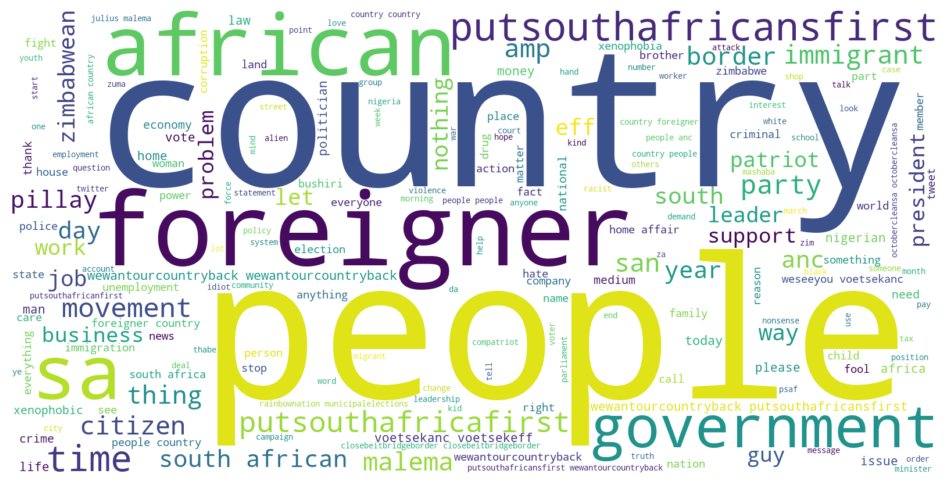

In [275]:
# select only noun for word cloud
tagset = df_lemmatized
tagset_allowed = ['n']
new_tagset = tagset.loc[tagset['Tag'].isin(tagset_allowed)]
text = ' '.join(str(x) for x in new_tagset['Lemmatized Noun'])
wordcloud = WordCloud(width = 1600, height = 800, max_words = 200, background_color = 'white').generate(text)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
#plt.savefig('Vis/Noun_WordCloud.png') # if you want to save the WordCloud
plt.show()

Based on the Word Cloud of Nouns, the nouns that are frequently used in the title are eff, senekal, farmer, protest and brendin horner.

b. Adjective

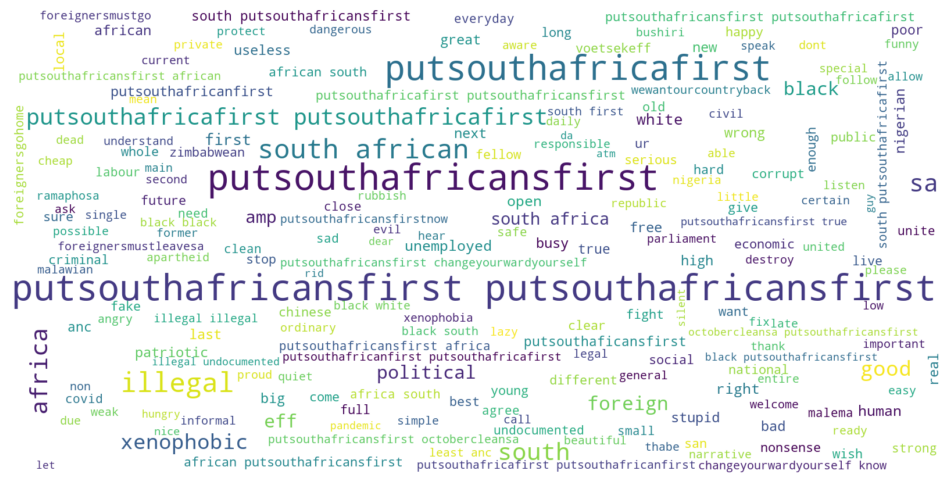

In [276]:
# select only adjectives for word cloud
tagset = df_lemmatized
tagset_allowed = ['a']
new_tagset = tagset.loc[tagset['Tag'].isin(tagset_allowed)]
text = ' '.join(str(x) for x in new_tagset['Lemmatized Adjective'])
wordcloud = WordCloud(width = 1600, height = 800, max_words = 200, background_color = 'white').generate(text)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
#plt.savefig('Vis/Adjectives.png')
plt.show()

The frequently used adjectives in the titles are neural, deep, artificial, big, new and fun.

c. Verb

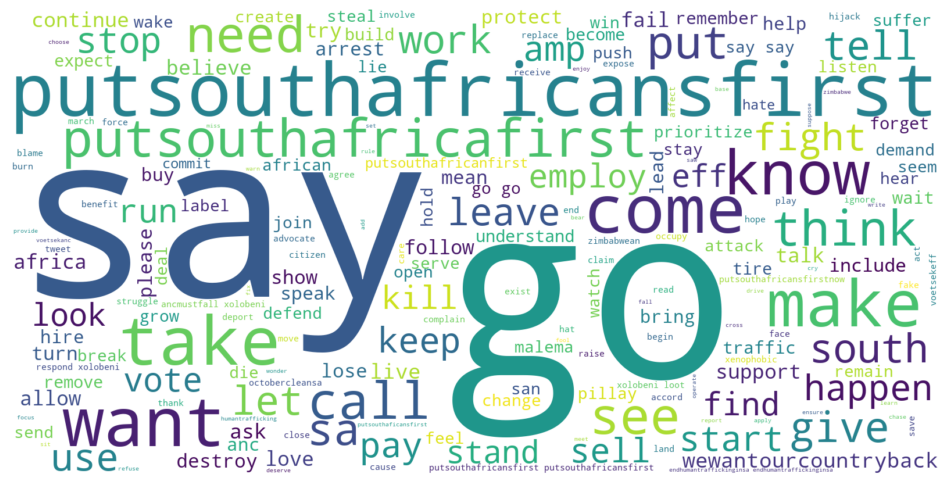

In [277]:
# select only verbs for word cloud
tagset = df_lemmatized
tagset_allowed = ['v']
new_tagset = tagset.loc[tagset['Tag'].isin(tagset_allowed)]
text = ' '.join(str(x) for x in new_tagset['Lemmatized Verb'])
wordcloud = WordCloud(width = 1600, height = 800, max_words = 200, background_color = 'white').generate(text)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
#plt.savefig('Vis/Adjectives_BeforeStemming.png')
plt.show()

The frequently shown verbs in the titles are learning (learn), use, deep, understand, happen and interview. At this stage, we can roughly see the topics which are frequently discussed by combining the Word Cloud of Nouns, Adjectives and Verbs. The topics are the neural network, data science, machine learning, deep learning and artificial intelligence.

Then, based on the Word Cloud of Verbs, we can identify the objective of the article. For example,

Use, learn, explain, build — The articles with these keywords are the tutorial of using a package, tool or an algorithm
Interview — The articles with this keyword are the advice or guide on the interview
Bigram
For bigram and trigram Word Cloud, we will need to use Count Vectorizer to calculate the frequency.

In [278]:
#Using count vectoriser to view the frequency of bigrams
tagset_allowed = ['a','n','v']
new_tagset = df_lemmatized.loc[df_lemmatized['Tag'].isin(tagset_allowed)]
text = [' '.join(str(x) for x in new_tagset['Lemmatized Word'])]
#print(text)

[('south african', 7187), ('south africa', 3141), ('putsouthafricansfirst putsouthafricansfirst', 2578), ('putsouthafricansfirst wewantourcountryback', 2142), ('wewantourcountryback putsouthafricansfirst', 1943), ('illegal immigrant', 1267), ('putsouthafricafirst putsouthafricafirst', 1008), ('voetsekanc voetsekeff', 891), ('illegal foreigner', 784), ('foreign national', 695), ('political party', 688), ('putsouthafricansfirst octobercleansa', 580), ('home affair', 557), ('wewantourcountryback wewantourcountryback', 536), ('country putsouthafricansfirst', 532), ('weseeyou voetsekanc', 511), ('putsouthafricansfirst movement', 485), ('voetsekeff putsouthafricansfirst', 462), ('call xenophobic', 452), ('people xolobeni', 449), ('putsouthafricansfirst putsouthafricafirst', 439), ('african putsouthafricansfirst', 429), ('black people', 418), ('human traffic', 416), ('putsouthafricafirst wewantourcountryback', 404), ('open border', 391), ('go home', 377), ('putsouthafricansfirst pillay', 376)

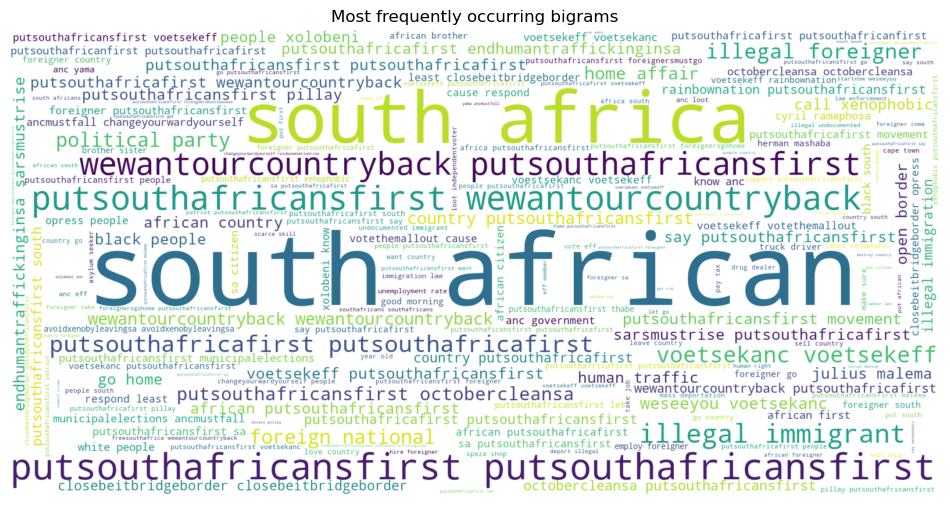

In [279]:

vectorizer = CountVectorizer(ngram_range=(2, 2))
bag_of_words = vectorizer.fit_transform(text)
vectorizer.vocabulary_
sum_words = bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
print (words_freq[:100])
#Generating wordcloud and saving as jpg image
words_dict = dict(words_freq)
WC_height = 800
WC_width = 1600
WC_max_words = 200
wordCloud = WordCloud(max_words=WC_max_words, height=WC_height, width=WC_width,background_color = 'white')
wordCloud.generate_from_frequencies(words_dict)
plt.title('Most frequently occurring bigrams')
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis("off")
plt.show()
wordCloud.to_file('wordcloud_bigram_putsafirst.jpg')

From Bigram Word Cloud, we can see more meaningful phrases than unigram. For example, reinforcement learning, learn TensorFlow, raspberry pi, beginner guide, image segmentation and silicon valley.

Let see what we can find with the Trigram Word Cloud.

Trigram
Same with bigrams, we will have to calculate the frequency with Count Vectorizer first.

[('putsouthafricansfirst putsouthafricansfirst putsouthafricansfirst', 782), ('weseeyou voetsekanc voetsekeff', 511), ('putsouthafricansfirst wewantourcountryback putsouthafricansfirst', 450), ('south african putsouthafricansfirst', 378), ('endhumantraffickinginsa sarsmustrise putsouthafricafirst', 344), ('sarsmustrise putsouthafricafirst endhumantraffickinginsa', 344), ('wewantourcountryback putsouthafricansfirst wewantourcountryback', 341), ('putsouthafricafirst putsouthafricafirst putsouthafricafirst', 300), ('rainbownation putsouthafricansfirst municipalelections', 295), ('putsouthafricansfirst putsouthafricansfirst wewantourcountryback', 290), ('putsouthafricansfirst municipalelections ancmustfall', 278), ('wewantourcountryback putsouthafricansfirst putsouthafricansfirst', 271), ('putsouthafricafirst endhumantraffickinginsa sarsmustrise', 260), ('closebeitbridgeborder closebeitbridgeborder closebeitbridgeborder', 247), ('wewantourcountryback wewantourcountryback putsouthafricansfi

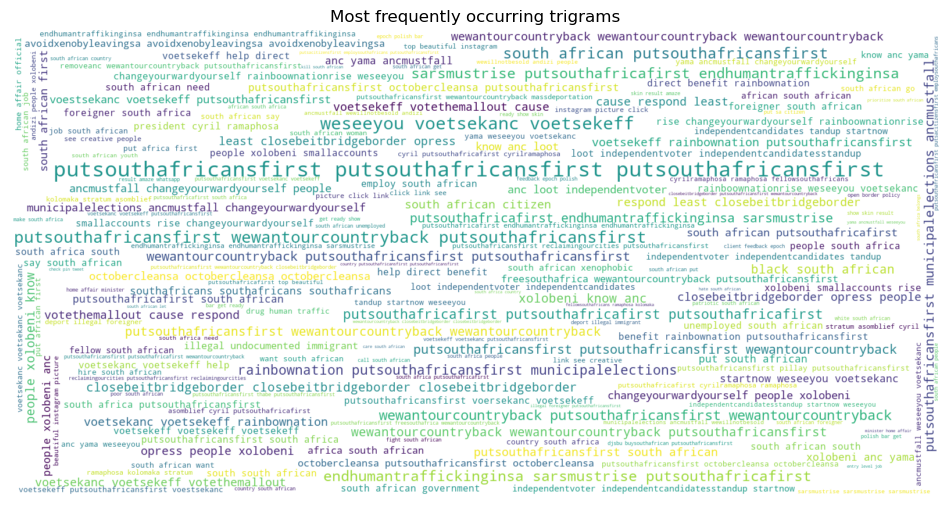

In [280]:
#Using count vectoriser to view the frequency of trigrams
vectorizer = CountVectorizer(ngram_range=(3, 3))
bag_of_words = vectorizer.fit_transform(text)
vectorizer.vocabulary_
sum_words = bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
print (words_freq[:100])
#Generating wordcloud and saving as jpg image
words_dict = dict(words_freq)
WC_height = 800
WC_width = 1600
WC_max_words = 200
wordCloud = WordCloud(max_words=WC_max_words, height=WC_height, width=WC_width,background_color = 'white')
wordCloud.generate_from_frequencies(words_dict)
plt.title('Most frequently occurring trigrams')
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis("off")
plt.show()
wordCloud.to_file('wordcloud_trigram_putsafirst.jpg')

The frequent phases are almost similar to bigrams, except the ‘detect object deep’, ‘recognition deep learning’ and ‘deep learning raspberry’. The first two trigrams shall be meant for object detection with deep learning and image recognition with deep learning respectively, while for the third trigram, I am not sure about it.

In [281]:
##searching text for specific phrase
# using the pre-process data
'''
title = df['title'].values
keyline = []
for line in title:
    line = line.lower()
    result = re.search(r"(^|[^a-z])" + "raspberry pi" + r"([^a-z]|$)", line)
    if result != None:
        keyline.append(line)
'''

'\ntitle = df[\'title\'].values\nkeyline = []\nfor line in title:\n    line = line.lower()\n    result = re.search(r"(^|[^a-z])" + "raspberry pi" + r"([^a-z]|$)", line)\n    if result != None:\n        keyline.append(line)\n'

In [283]:
## find frequently used words that are unique to each class
role_lst = list(df_user['Position_3'].unique())
word_cloud_dict_lst = []
for i in role_lst:
    #print(i)
    role_tweets = ' '.join(text for text in df_user['clean_text2'][df_user['Position_3']==i])
    #convert it to dictionary with values and its occurences
    my_list = list(role_tweets.split(" "))
    #print(my_list)
    
    #convert it to dictionary with values and its occurences
    word_could_dict=Counter(my_list)
    word_cloud_dict_lst.append(word_could_dict)
    
for i,tf in enumerate(word_cloud_dict_lst):
    tf_key_lst = []
    print(role_lst[i])
    k_lst = list(word_cloud_dict_lst[i].keys())
    for e,x in enumerate(word_cloud_dict_lst):
        if e != i:
            #print(e, list(x.keys())[:10])
            tf_key_lst.append(list(x.keys()))
    #tmp_lst = [(x for x in list(tf_lst[each].keys())) for each in range(6) if each != 0
    #print(k_lst[:30])
    #print("--------------")
    #print(tf_key_lst[0][:30])
    print("--------------")
    print(list(set(k_lst) - set(tf_key_lst[0]))[:30])

Activator
--------------
['anti-legal', 'centre-', 'alllivesmattter', 'peosperous', 'closet', 'nyaka', 'mosquarading', 'illegalbusinessinsago', 'emathanjeni', 'profet', 'nailing', 'mkhatshwa', 'aslo', 'bugger', 'subtiltles', 'nkunkuma', 'adrean', 'cyring', 'foreigners-leave', 'fuuuuckers', 'batagilwe', 'buharimuststay', 'tzn', 'casted', 'water-shedding', 'unsung', 'ixoxo', 'methadone', 'deprt', '-internet']
Minor
--------------
['outta', 'ineptness', 'cayenne', 'mhlahlo', 'bidenlied', 'dids', 'menifsto', 'mosybof', 'absa', 'xplasma', 'woodworms', 'progressives', 'mahloni', 'guccinaries', '-senior', 'supportlocalcreatives', 'rsanam', 'ramp', 'iifebe', 'meanig', 'botsotsi', 'bethatha', 'atlantic', 'maye', 'angwafuni', 'putsouthafricansfirsr', 'douglas', 'notoinfluxofimmigrants', 'enclave', 'npos']
Leader
--------------
['intra-african', 'md', 'title', 'mpumalangapremier', 'pinetown', 'newyearseve', 'traficking', 'wewillneverforget', 'senekalshowdown', 'covax', 'sgwegwe', 'opponents', 'al

Activator
123954
Minor
343227
Leader
21554
Observer
11828
Activator
123954 89765
512


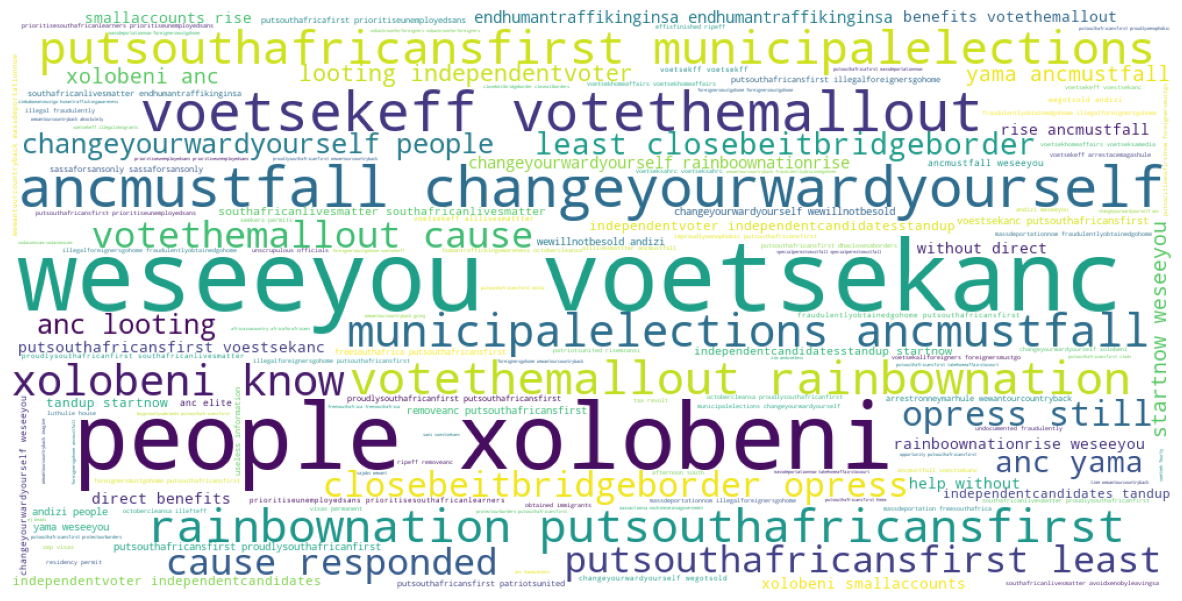

Minor
343227 309038
340


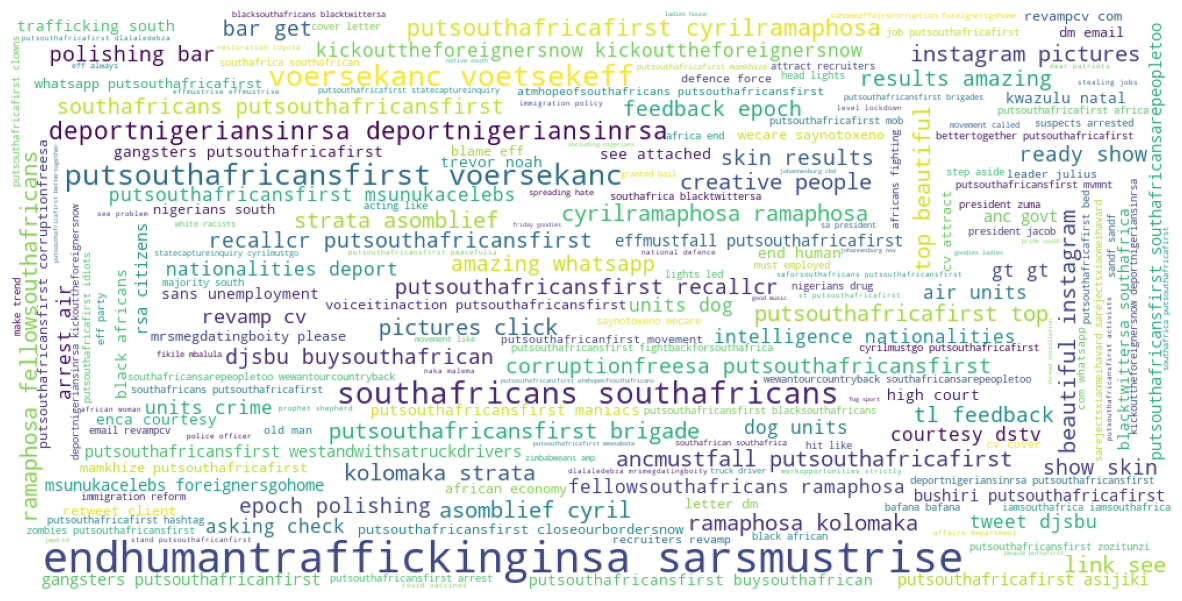

Leader
21554 17691
24


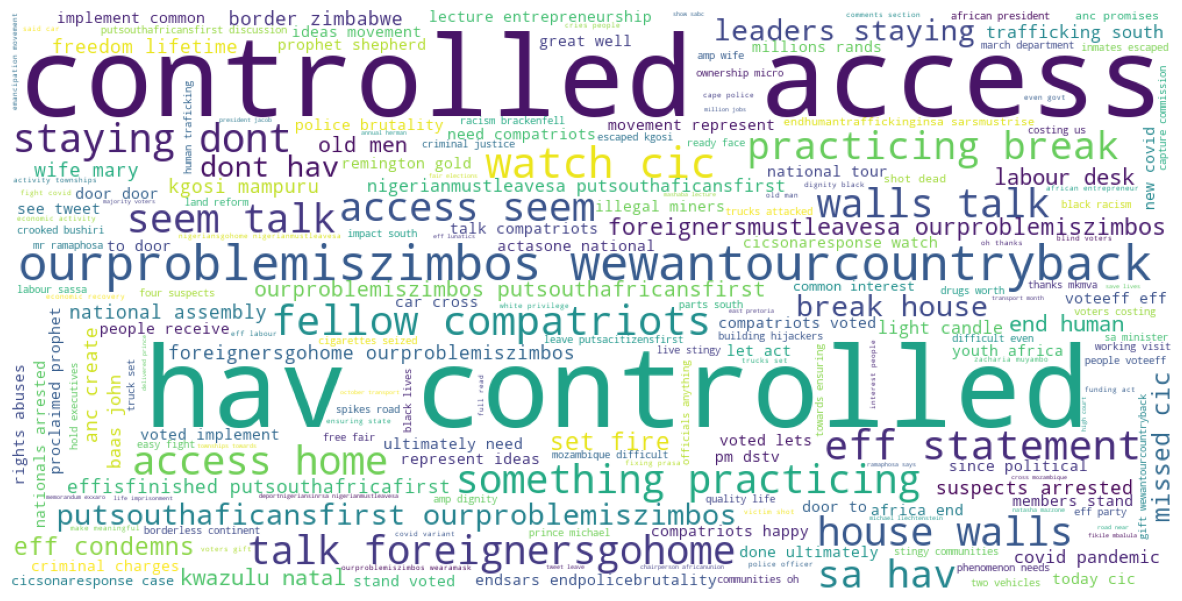

Observer
11828 9357
25


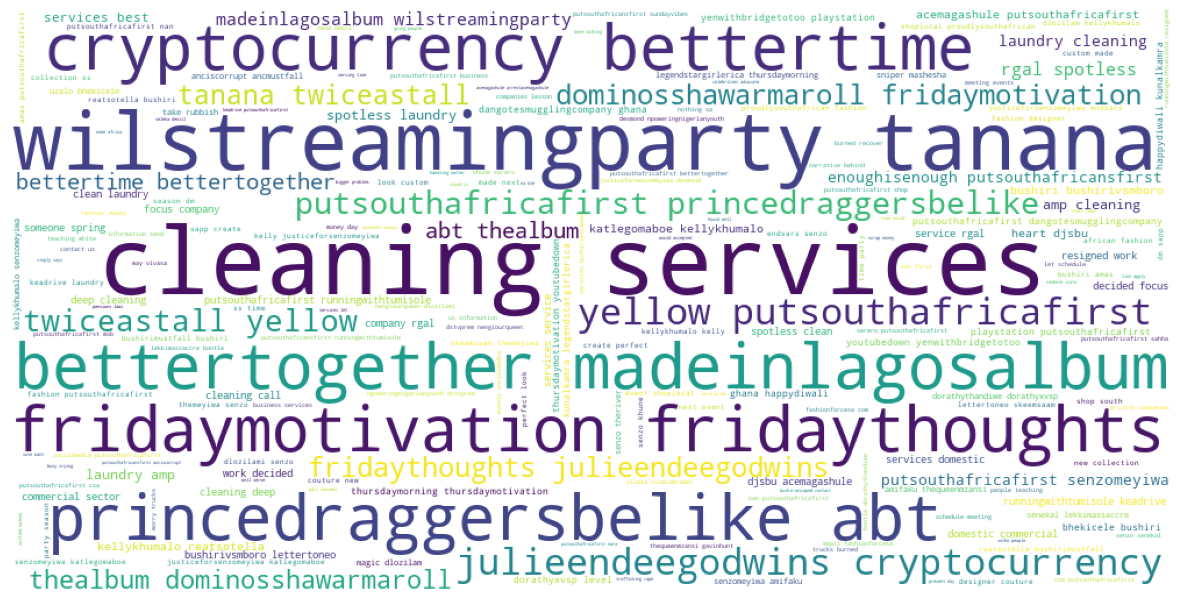

In [286]:
#Using count vectoriser to view the frequency of bigrams
role_lst = list(df_user['Position_3'].unique())
word_cloud_dict_lst = []
for i in role_lst:
    print(i)
    role_tweets = [' '.join(str(text) for text in df_user['clean_text2'][df_user['Position_3']==i])]
    #convert it to dictionary with values and its occurences
    vectorizer = CountVectorizer(ngram_range=(2, 2))
    bag_of_words = vectorizer.fit_transform(role_tweets)
    vectorizer.vocabulary_
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    #print (words_freq[:100])
    print(len(words_freq))
    words_dict = dict(words_freq)
    word_cloud_dict_lst.append(words_dict)

for i,wc in enumerate(word_cloud_dict_lst):
    print(role_lst[i])
    wc_key_lst = []
    k_lst = list(wc.keys())
    #print(tf['continuation'])
    for e,x in enumerate(word_cloud_dict_lst):
        if e != i:
            #print(e, list(x.keys())[:10])
            wc_key_lst.append(list(x.keys()))
    wc_lst = list(set(k_lst) - set(wc_key_lst[0]))
    print(len(k_lst), len(wc_lst))
    #print(wc_lst)
    try:
        word_cloud_dict2 = {k: wc[k] for k in wc_lst}
        tmp_lst = [wc[k] for k in wc_lst]
        print(max(tmp_lst))
        #print(word_cloud_dict2)
        
        WC_max_words = 200
        wordcloud = WordCloud(max_words=WC_max_words,width = 1000, height = 500,background_color = 'white')
        wordcloud.generate_from_frequencies(word_cloud_dict2)
        plt.figure(figsize=(15,8))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.savefig('wordcloud_bigram_putsafirst_' +role_lst[i]+'.jpg', bbox_inches='tight')
        plt.show()
        
    except Exception as e:
        print(e)
#plt.close()


In [158]:

#df = df.query('~Text.str.contains("amber|heard|johnny|depp|shannon|curry")')
#sentiment_pipeline = pipeline(model="cardiffnlp/twitter-roberta-base-sentiment")
sentiment_pipeline = pipeline(model="cardiffnlp/twitter-roberta-base-sentiment-latest")

#cardiffnlp/twitter-roberta-base-sentiment-latest

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [159]:
import pickle
#I also noticed some tweets containing URLs. I am just going to remove all the URLs in the tweets.

#df_user = df_user.assign(sentiment=lambda x: x['text2'].apply(lambda s: sentiment_pipeline(s)))
#pickle_obj = pickle.dumps(df_user)
#df_user = pickle.loads(pickle_obj)
#df_user.to_csv(pth+'sentiment_hate_speech.csv')

In [160]:
df_user1.head()

NameError: name 'df_user1' is not defined

In [ ]:

import ast

df_user1 = pd.read_csv(pth+'sentiment_hate_speech.csv')


df_user1['sentiment2'] = [ast.literal_eval(i) for i in df_user['sentiment']]
df_user1 = df_user1.assign(sentiment_label=lambda x: x['sentiment2'].apply(lambda s: s[0]['label']))
df_user1 = df_user1.assign(sentiment_score=lambda x: x['sentiment2'].apply(lambda s: s[0]['score']))
df_user1.head()

In [ ]:

role_lst = ['Minor','Informer', 'Leader', 'Spreader', 'Observer', 'Activator']



df_user = df_user1.assign(
    sentiment_label=np.where(
        df_user1['sentiment_label']=='negative', 'NEGATIVE', np.where(
            df_user1['sentiment_label']=='positive', 'POSITIVE', 'NEUTRAL'
        )
    )
)

df_minor = df_user1.loc[df_user1['Position_5']=='Minor']
df_informer = df_user1.loc[df_user1['Position_5']=='Informer']
df_leader = df_user1.loc[df_user1['Position_5']=='Leader']
df_spreader = df_user1.loc[df_user1['Position_5']=='Spreader']
df_observer = df_user1.loc[df_user1['Position_5']=='Observer']
df_activator = df_user1.loc[df_user1['Position_5']=='Activator']
                       
                       

In [ ]:
df_user1['sentiment_label'].value_counts()

In [ ]:
dfc = pd.concat([
    df_minor.query('sentiment_score>0')['sentiment_label'].value_counts(),
    df_informer.query('sentiment_score>0')['sentiment_label'].value_counts(),
    df_leader.query('sentiment_score>0')['sentiment_label'].value_counts(),
    df_spreader.query('sentiment_score>0')['sentiment_label'].value_counts(),
    df_observer.query('sentiment_score>0')['sentiment_label'].value_counts(),
    df_activator.query('sentiment_score>0')['sentiment_label'].value_counts()
], axis=1)
dfc.columns = ['Minor','Informer', 'Leader', 'Spreader', 'Observer', 'Activator']
dfc

--------------------------------

##Sentiment Analysis

Run the following lines of code to import the NLTK library, along with the SentimentIntensityAnalyzer (SID) module.

The SID module takes in a string and returns a score in each of these four categories — positive, negative, neutral, and compound.

The compound score is calculated by normalizing the positive, negative, and neutral scores. If the compound score is closer to 1, then the Tweet can be classified as positive. If it is closer to -1, then the Tweet can be classified as negative.

In [120]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
import re
import pandas as pd
import nltk
nltk.download('words')
words = set(nltk.corpus.words.words())

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\SALDRU1\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\SALDRU1\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [154]:
def cleaner(tweet):
    tweet = re.sub("@[A-Za-z0-9]+","",tweet) #Remove @ sign
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet) #Remove http links
    tweet = " ".join(tweet.split())
    tweet = tweet.replace("#", "").replace("_", " ") #Remove hashtag sign but keep the text
    tweet = " ".join(w for w in nltk.wordpunct_tokenize(tweet)
         if w.lower() in words or not w.isalpha())
    return tweet
    
df_user['text2'] = df_user['text'].apply(cleaner)

In [ ]:
sentence = "this is disgusting if a white man did this the whole world would hear about it why does the eff not march on this area like senekal"
sid.polarity_scores(sentence)['compound']

-------------------------------

In [99]:
#Calculating Negative, Positive, Neutral and Compound values
df_user[['polarity', 'subjectivity']] = df_user['text2'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
for index, row in df_user['text2'].iteritems():
    score = SentimentIntensityAnalyzer().polarity_scores(row)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    if neg > pos:
        df_user.loc[index, 'sentiment'] = "negative"
    elif pos > neg:
        df_user.loc[index, 'sentiment'] = "positive"
    else:
        df_user.loc[index, 'sentiment'] = "neutral"
        df_user.loc[index, 'neg'] = neg
        df_user.loc[index, 'neu'] = neu
        df_user.loc[index, 'pos'] = pos
        df_user.loc[index, 'compound'] = comp
df_user.head(10)

id  \
0  1000097360138178561   
1           1000194740   
2            100019857   
3  1000274007915155456   
4  1000416117125468162   
5  1000463123281793024   
6  1000510947792846854   
7  1000544380082704384   
8  1000651384801366016   
9  1000708579417055232   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       text  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              RT @Hluvukanii: 😂 Today they're praying, last time they were vandalizing. EFF know how to put hooligans in their place. #Senekal https://t.…   
1                                                                                                                                                                                                                                                                                                                                                                                      

In [ ]:
#finding polarity for each comment
polarity=[]
for i in df_user['text']:
    try:
        polarity.appended(TextBlob(i).sentiment.polarity)
    except:
        polarity.append(0)

In [59]:
for i in polarity:
    if i >0:
        print(i)

In [60]:
user_txt = df_user['text'].to_list()

Data Cleaning
The next step consists of cleaning up the tweets we obtained in the previous section. Social media data usually contains a lot of noise so multiple cleaning tasks must be carried out for further data processing. As shown below, we eliminate URLs, hashtags, and mentions from tweets using regular expressions in Python.

In this case, we decided to remove @ signs (mention) and # signs (hashtag) leaving the original term without modification (e.g. #happy is converted into happy). We decided to keep the terms of the hashtags because on many occasions these terms are used within a sentence and are necessary to understand its meaning (e.g. I am really #happy with the new season). Additionally, we will also remove punctuation marks in the data.

For the cleaning of tweets, we define the function clean_tweet. This function removes URLs, punctuation marks, #, and @ from a text (in this case a tweet).

In [61]:
def clean_tweet(tweet):
    '''
    Function to clean a tweet text by removing the links, punctuations, hashtags, and mentions symbols
    using regex expressions.
    Parameters:
       tweet (string): Tweet text to transform.
    Returns:
       tweet_cleaned (string): Tweet without links, punctuations, hashtags, and mentions symbols. 
    """
    ''' U+2070 
    # convert the tweet text to lowercase letters
    tweet_lower = tweet.lower()
    # remove links, punctuations, hashtags, and mentions
    tweet_cleaned = re.sub(u"(http\S+)|([“”!?])|([#@])", "", tweet_lower)
    
    return tweet_cleaned

After applying the function to each of the tweets, we visualize the results.

In [62]:
# we apply the funtion clean_tweet to each tweet
user_text_cleaned = [clean_tweet(tweet) for tweet in user_txt]
# we visualize the first 10 tweets
print(user_text_cleaned[:10])

["rt hluvukanii: 😂 today they're praying, last time they were vandalizing. eff know how to put hooligans in their place. senekal ", 'rt justcallmesihle: rapists - roaming free\nkillers  - roaming free\nsenekal farmers - roaming free\ndrug and human traffickers roaming free…', 'rt lonestar_skye: how. many. more. farmers\n\nrip brendin horner 💔 ', 'rt cweillraynal: brendin horner, fermier blanc  sud-africain de 21 ans, assassiné le 2 octobre, retrouvé pendu à un poteau : dans combien…', "rt power987news: watch: eff supporters and farmers stand toe-to-toe in senekal. brendinhorner  abongiledumako: watch: julius_s_malema thanks effsouthafrica members for their bravery and participated in today's protest in seneka…", 'rt the_alexios: the way white farmers of senekal are playing victim in this crisis is unsettling.\n\na week ago they stormed into a courtho…', '📷 farmmurders eff racism blackracism stopfarmkillings juliusmalema nofarmersnofood farmerlivesmatter whitegenocide brendinhorner sene

In [63]:
def opinion_words_txt2dict(opinion_words_file_path):
    """
    Converts a txt file of opinion words into a Python dictionary.
    Parameters:
       opinion_words_file_path (string): Path where the txt file is located.
    Returns:
       opinion_words_dictionary (dict): Python dictionary containing the opinion words.  
    """
    opinion_words_dictionary = dict()

    with open(opinion_words_file_path, 'r') as of:
        # we read the content of the file in the form of a list where each element is a line of the file
        opinion_words = of.readlines()
        # we iterate through each line of the file (a line contains an opinion word and its polarity)
        for opinion_word in opinion_words:
            word, polarity = opinion_word.strip().split('\t')
            # we add each opinion word and its polarity to the Python dictionary
            opinion_words_dictionary[word] = int(polarity)
            
    return opinion_words_dictionary

In [64]:

# we read the AFINN dictionary file and store the content in a Python dictionary called opinion_words_dictionary
opinion_words_file_path = 'AFINN-111.txt'
opinion_words_dictionary = opinion_words_txt2dict(opinion_words_file_path)

# we visualize the dictionary
#print(opinion_words_dictionary)

In [65]:
# we merge both dictionaries into a unique dictionary
polarity_dictionary = {**opinion_words_dictionary}

def tweet_polarity(tweet, polarity_dictionary):
    """
    Computes the polarity of a tweet as the sum of the polarity of each of the opinion words and emojis in the tweet.
    Parameters:
       tweet (string): Tweet to analyze.
       polarity_dictionary(dictionary): Dictionary with the polarity of the opinion words and emojis.
    Returns:
       The polarity of a tweet (tweet_polarity), if the tweet contains opinion words or emojis, otherwise, None.  
    """
    # we get the polarity of the opinion words and emojis of the tweet
    word_polarities = [polarity_dictionary.get(word) for word in tweet.split()
                        if polarity_dictionary.get(word)]
    
    # if word_polarities is not empty we return the sum of the polarities of the opinion words and emojis of the tweet
    if word_polarities:
        # we calculate the polarity of a tweet as the sum of the polarities of its opinion words and emojis
        tweet_polarity = np.sum(word_polarities)
        return tweet_polarity
    
    # if word_polarities is empty, meaning there are not words with polarity in the tweet, the function returns None
    else:
        return None

In [66]:
# we compute the polarity of each tweet and we store the data in a list
polarities = [tweet_polarity(tweet, polarity_dictionary) for tweet in user_text_cleaned]

# we visualize the polarity of the first 10 tweets
polarities[:10]

[-2, 3, None, None, 1, -6, -3, -1, None, -2]

In [100]:
# we store the tweet_text and its polarity in a dataframe for further analysis
df_user['text_2'] = user_text_cleaned
df_user['polarity'] = polarities

# we visualize the first 5 tweets
df_user[20:40]

id  \
20  1001446821405843456   
21  1001460244466356224   
22  1001494989220786177   
23  1001517960647802880   
24  1001525900356280320   
25  1001528422215180288   
26  1001581233103605762   
27  1001602018891399169   
28  1001722205473050624   
29  1001727346523729921   
30  1001727731472781317   
31  1001738118200987648   
32  1001830069000695808   
33            100194695   
34  1001956052458459136   
35  1002088118500188160   
36  1002117215594872832   
37  1002152464739700739   
38  1002191152190251008   
39            100219151   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      text  \
20                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            RT @LouisRielFrance: La sauvagerie avec laquelle a été assassiné Brendin Horner, jeune paysan blanc de 21 ans en #AfriqueduSud, dépasse l'e…   
21                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          RT @justcallmesihle: Rapists - Roaming free\nKillers  - Roaming free\nSenekal farmers - Roaming free\nDrug and human traffickers roaming free…   
22                                                 

As shown above, the mean polarity is positive, meaning the reaction of the public after the release of the second season was favorable. However, more interesting than simply knowing the mean of polarities is to know the distribution of probabilities, for example, by using a histogram.

In [70]:

print(df_user['polarity'].mean())

#sorted(df_user['polarity'].to_list(),reverse=True)

-4.41357274887774

In [71]:
# we visulize the polarity of the tweets with the #bridgerton
df_user.polarity.plot(kind='hist')
# we set the title of the plot
plt.title('Polarity of the tweets with the #bridgerton', loc='left', fontsize=14)

Text(0.0, 1.0, 'Polarity of the tweets with the #bridgerton')

In [ ]:
#Sentiment Analysis
def percentage(part,whole):
    return 100 * float(part)/float(whole)
#keyword = input(“Please enter keyword or hashtag to search: “)
#noOfTweet = int(input (“Please enter how many tweets to analyze: “))
#tweets = tweepy.Cursor(api.search, q=keyword).items(noOfTweet)
positive = 0
negative = 0
neutral = 0
polarity = 0
tweet_list = []
neutral_list = []
negative_list = []
positive_list = []

for tweet in tweets:
    #print(tweet.text)
    tweet_list.append(tweet.text)
    analysis = TextBlob(tweet.text)
    score = SentimentIntensityAnalyzer().polarity_scores(tweet.text)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    polarity += analysis.sentiment.polarity
 
    if neg > pos:
        negative_list.append(tweet.text)
        negative += 1
    elif pos > neg:
        positive_list.append(tweet.text)
        positive += 1
    elif pos == neg:
        neutral_list.append(tweet.text)
        neutral += 1
    
positive = percentage(positive, noOfTweet)
negative = percentage(negative, noOfTweet)
neutral = percentage(neutral, noOfTweet)
polarity = percentage(polarity, noOfTweet)
positive = format(positive, '.1f')
negative = format(negative, '.1f')
neutral = format(neutral, '.1f')